In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import TensorBoard
from keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Model
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import googlenet
from PIL import Image
import time 
from keras.callbacks import Callback
from sklearn.metrics import classification_report

In [2]:
# GLOBAL VARIABLES
path = "data1/NITROHCS_V1.0/"
Test_Ratio = 0.2
ValRatio = 0.2
images = []
classid = []
inputShape = (128,128,3)
batchsizeVal = 80
epochsVal = 50

In [3]:
myList = os.listdir(path)
noofclasses = len(myList)
print("No of Classes Detected = ",noofclasses)

print("Importing Classes...")

for x in range(0,noofclasses):
    picList = os.listdir(path+"/"+myList[x])
    for y in picList:
        curImg = cv2.imread(path+"/"+myList[x]+"/"+y)
        curImg = cv2.resize(curImg,(inputShape[0],inputShape[1]))
        images.append(curImg)
        classid.append(x)
    print(x,end=" ")
print(" ")    
print("No of images imported = ",len(images)) 

# To convert into numpy array
images = np.array(images)
classid = np.array(classid)

print(images.shape)
print(classid.shape)

No of Classes Detected =  47
Importing Classes...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46  
No of images imported =  15040
(15040, 128, 128, 3)
(15040,)


In [4]:
classid = classid.reshape(-1, 1)
noOfClasses = classid
onehotencoder = OneHotEncoder()
Y = onehotencoder.fit_transform(classid).toarray()

images, Y = shuffle(images, Y, random_state=69)

x_train, x_test, y_train, y_test = train_test_split(
    images, Y, test_size=0.2, random_state=69)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=0.2, random_state=69)

print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)

(9625, 128, 128, 3)
(3008, 128, 128, 3)
(2407, 128, 128, 3)


In [5]:
# x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
# x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
# num_classes = 10
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128,128,3))

In [7]:
inputs = tf.keras.Input(shape=(128, 128, 3))
rescaled_inputs = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
resized_inputs = tf.keras.layers.experimental.preprocessing.Resizing(128, 128)(rescaled_inputs)
base_model_output = base_model(resized_inputs)
flattened_output = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
dense_layer = Dense(256, activation='relu')(flattened_output)
dropout_layer = Dropout(0.5)(dense_layer)
output = Dense(47, activation='softmax')(dropout_layer)
model = Model(inputs=inputs, outputs=output)

In [8]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [9]:
epochs = 10
tensorboard_callback = TensorBoard(log_dir='./logs')
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
history = model.fit(x_train, y_train, epochs=epochs, verbose=1,
          validation_data=(x_validation, y_validation), callbacks=[tensorboard_callback,time_callback])

Epoch 1/10
301/301 [==============================] - 1374s 5s/step - loss: 2.0822 - accuracy: 0.4564 - val_loss: 1.5748 - val_accuracy: 0.6136
Epoch 2/10
301/301 [==============================] - 1630s 5s/step - loss: 0.7020 - accuracy: 0.8076 - val_loss: 0.4634 - val_accuracy: 0.8741
Epoch 3/10
301/301 [==============================] - 1324s 4s/step - loss: 0.4770 - accuracy: 0.8738 - val_loss: 0.4534 - val_accuracy: 0.8803
Epoch 4/10
301/301 [==============================] - 1396s 5s/step - loss: 0.3318 - accuracy: 0.9140 - val_loss: 0.5736 - val_accuracy: 0.8592
Epoch 5/10
301/301 [==============================] - 1275s 4s/step - loss: 0.2584 - accuracy: 0.9319 - val_loss: 0.2917 - val_accuracy: 0.9294
Epoch 6/10
301/301 [==============================] - 1048s 3s/step - loss: 0.2010 - accuracy: 0.9470 - val_loss: 0.2968 - val_accuracy: 0.9314
Epoch 7/10
301/301 [==============================] - 3568s 12s/step - loss: 0.2230 - accuracy: 0.9420 - val_loss: 0.4360 - val_accuracy

In [10]:
print (sum(time_callback.times))

15020.16541337967


In [11]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94/94 [==============================] - 54s 571ms/step - loss: 0.1998 - accuracy: 0.9435
Test loss: 0.19983717799186707
Test accuracy: 0.9434840679168701


In [12]:
# Saving the model
pickle_out = open("model_trained_iitbbs_googlenet.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\functional
......vars
...layers\functional\layers\activation
......vars
...layers\functional\layers\activation_1
......vars
...layers\functional\layers\activation_10
......vars
...layers\functional\layers\activation_11
......vars
...layers\functional\layers\activation_12
......vars
...layers\functional\layers\activation_13
......vars
...layers\functional\layers\activation_14
......vars
...layers\functional\layers\activation_15
......vars
...layers\functional\layers\activation_16
......vars
...layers\functional\layers\activation_17
......vars
...layers\functional\layers\activation_18
......vars
...layers\functional\layers\activation_19
......vars
...layers\functional\layers\activation_2
......vars
...layers\functional\layers\activation_20
......vars
...layers\functional\layers\activati

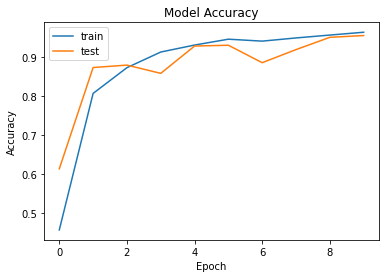

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

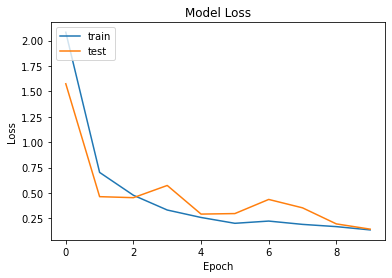

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
y_pred = model.predict(x_test)
y_pred = (y_pred >= 0.5)

print('Classification Report')
print(classification_report(y_test,y_pred))

94/94 [==============================] - 56s 584ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      0.98      0.99        60
           2       1.00      0.75      0.86        68
           3       0.80      0.89      0.84        53
           4       0.80      0.95      0.87        59
           5       0.98      0.77      0.86        74
           6       0.80      0.93      0.86        61
           7       0.79      0.92      0.85        65
           8       0.98      1.00      0.99        56
           9       1.00      0.95      0.97        55
          10       0.98      0.98      0.98        54
          11       0.92      1.00      0.96        61
          12       0.88      0.85      0.86        66
          13       1.00      0.99      0.99        70
          14       0.95      0.91      0.93        66
          15       1.00      0.91      0.95        66
   

c:\Users\ALIPSA SAHOO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
